In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates

from construct import *

import sys
sys.path.append('../Tianwen')
import ccsds

import collections
#import datetime
#import struct

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def load_frames(file):
    frame_size = 223 * 4 - 2  # CRC-16 is removed in flowgraph
    frames = np.fromfile(file, dtype = 'uint8')
    return frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)

frames = load_frames('integral_frames.u8')
frames.shape

(319, 890)

## TM Primary Headers

The frames are TM Space Data Link frames. The spacecraft ID is 121 (0x79). Virtual channels 0 and 7 are in use. OCF is used.

In [3]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

In [4]:
tm = [TMPrimaryHeader.parse(f) for f in frames]
scid = np.array([h.spacecraft_id for h in tm])
vcid = np.array([h.virtual_channel_id for h in tm])
v_framecount = np.array([h.virtual_channel_frame_count for h in tm])
m_framecount = np.array([h.master_channel_frame_count for h in tm])

In [5]:
tm[:5]

[Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=48, virtual_channel_frame_count=236, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=49, virtual_channel_frame_count=237, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=50, virtual_channel_frame_count=238, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=51, virtual_channe

In [6]:
collections.Counter(scid)

Counter({121: 319})

In [7]:
hex(121)

'0x79'

In [8]:
collections.Counter(vcid)

Counter({7: 294, 0: 25})

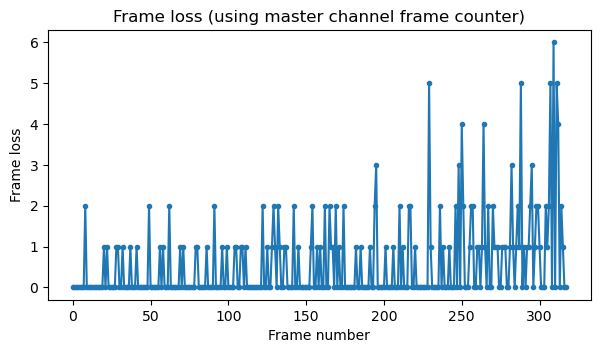

In [9]:
frame_loss = np.diff(m_framecount.astype('uint8')) - 1
plt.plot(frame_loss, '.-')
plt.title('Frame loss (using master channel frame counter)')
plt.ylabel('Frame loss')
plt.xlabel('Frame number');

In [10]:
# fraction of lost frames overall
np.sum(frame_loss) / (m_framecount[scid == 0x79].size + np.sum(frame_loss))

0.358148893360161

## Operational Control Field

The OCF alternates every other frame, showing the information corresponding to virtual channels 0 and 7. The contents of the OCF for each of these two virtual channels do not change throughout the recording.

In [11]:
ocf = frames[:, -4:]
np.unique(ocf, axis=0)

array([[ 1,  0,  6,  4],
       [ 1, 28,  4,  1]], dtype=uint8)

In [12]:
ocf[:5]

array([[ 1,  0,  6,  4],
       [ 1, 28,  4,  1],
       [ 1,  0,  6,  4],
       [ 1, 28,  4,  1],
       [ 1,  0,  6,  4]], dtype=uint8)

In [13]:
np.unique(ocf[m_framecount[scid == 0x79] % 2 == 0], axis=0)

array([[1, 0, 6, 4]], dtype=uint8)

In [14]:
np.unique(ocf[m_framecount[scid == 0x79] % 2 == 1], axis=0)

array([[ 1, 28,  4,  1]], dtype=uint8)

In [15]:
print(CLCW.parse(ocf[0]))

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 0
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 3
    rsvd_spare2 = 0
    report_value = 4


In [16]:
print(CLCW.parse(ocf[1]))

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 7
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 2
    rsvd_spare2 = 0
    report_value = 1


## Virtual channel 0

Virtual channel 0 is used to transmit telemetry data. The first header point is always zero. The 880 byte transfer frame data field seems to be divided in two sections of 440 bytes carrying some kind of packets (but not Space Packets).

In [17]:
[t for t in tm if t.virtual_channel_id == 0][:5]

[Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=90, virtual_channel_frame_count=69, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=122, virtual_channel_frame_count=70, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=135, virtual_channel_frame_count=71, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=138, virtual_channel_frame_c

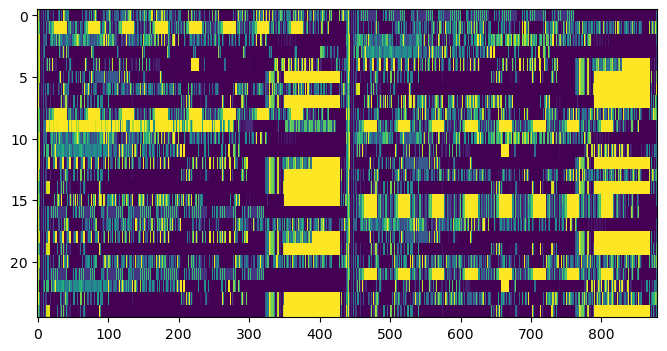

In [18]:
plt.figure(figsize=(8, 4))
plt.imshow(frames[vcid == 0, 6:-4], aspect='auto', interpolation='none')

## Virtual channel 7

Virtual channel 7 contains idle data. The transfer frame data field is filled with a PN9 sequence.

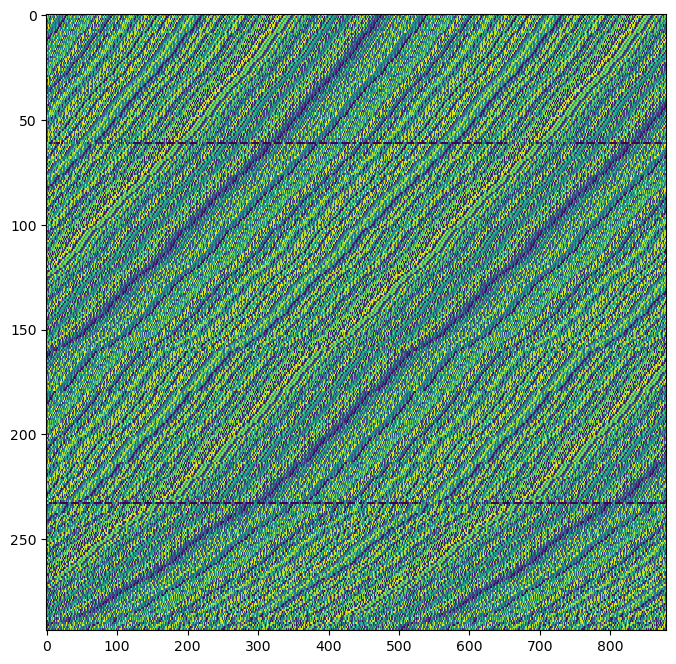

In [19]:
plt.figure(figsize=(8, 8))
plt.imshow(frames[vcid == 7, 6:-4], aspect='auto', interpolation='none')

In [20]:
lfsr = np.ones(9, dtype = 'uint8')
lfsr_out = np.empty(511, dtype = 'uint8')
for j in range(lfsr_out.size):
    out = lfsr[8] ^ lfsr[4]
    lfsr_out[j] = lfsr[8]
    lfsr = np.roll(lfsr, 1)
    lfsr[0] = out

In [21]:
bits = np.unpackbits(frames[vcid == 7, 6:-4], axis=1)
f = np.fft.fft(2 * bits[:, :511].astype('float') - 1)
g = np.fft.fft(2 * lfsr_out.astype('float') - 1)
fg = np.fft.ifft(f * np.conjugate(g))
peak = np.argmax(fg.real, axis=1)

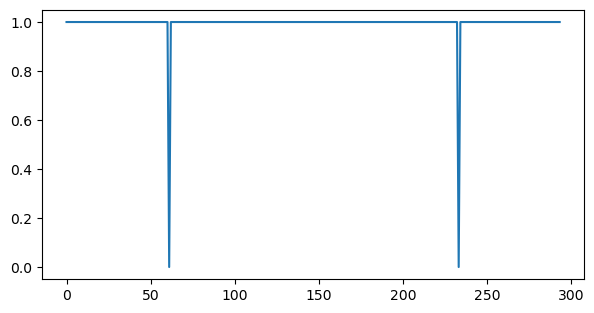

In [22]:
matches = np.array([np.all(bits[j] == np.tile(np.roll(lfsr_out, peak[j]), 14)[:bits.shape[1]])
                    for j in range(bits.shape[0])])
plt.plot(matches)

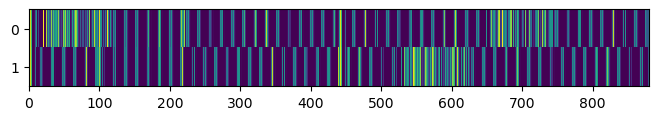

In [23]:
plt.figure(figsize=(8, 1))
plt.imshow(frames[vcid == 7, 6:-4][~matches], aspect='auto', interpolation='none')

In [24]:
frames[vcid == 7, 6:-4][~matches][0].reshape(-1, 8)

array([[140,  64, 240, 169,   1, 177,   0,   8],
       [115,  73, 128,  32,   0,  52,   0,   0],
       [  0,   0,   0,   0, 252, 100,   0,   0],
       [221,  19,  56, 132,  32,  68,  67, 209],
       [155,  75, 178,  69, 117, 142,   7, 155],
       [ 98, 208, 144,  70,  25,  23,  52,  22],
       [205,  71, 167, 215, 150,  73, 165,  18],
       [ 98, 161,   8,  37,  28, 141, 110,  54],
       [168, 216, 226, 209, 139, 197,  39,  18],
       [156,  78,  17,  64, 132,  66,  15,   8],
       [ 58,  38, 240, 112,  33, 208,   5,   3],
       [ 30,  13, 120,  66, 224, 216, 131,  97],
       [ 12, 133,  70,  28, 240, 132, 129, 224],
       [  7,  67,  31,  16, 100,  58,  32, 248],
       [132,   2,  18, 136,   0,  48,   8, 115],
       [ 71,  68, 128,  32,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   8, 115],
       [ 71, 100, 128,  32,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   8, 115],
       [ 71, 132, 128,  32,   0,   4,   0,   0],
       [  0,   0,   

In [25]:
[TMPrimaryHeader.parse(f) for f in frames[vcid == 7][~matches]]

[Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=126, virtual_channel_frame_count=55, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=121, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=140, virtual_channel_frame_count=49, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=1, first_header_pointer=0)]

In [26]:
mcfc = np.array([TMPrimaryHeader.parse(f).master_channel_frame_count
                 for f in frames[vcid == 7]])
vcfc = np.array([TMPrimaryHeader.parse(f).virtual_channel_frame_count
                 for f in frames[vcid == 7]])
mcfc_unwrap = np.int32(np.unwrap(mcfc / 256 * 2 * np.pi) * 256 / (2 * np.pi))
vcfc_unwrap = np.int32(np.unwrap(vcfc / 256 * 2 * np.pi) * 256 / (2 * np.pi))

In [27]:
peak[:10]

array([101,  85,  69,  53,  37,  21,   5, 500, 484, 436])

In [28]:
list(zip((peak + 16 * mcfc_unwrap)[matches] % 511, mcfc[matches], vcfc[matches]))

[(358, 48, 236),
 (358, 49, 237),
 (358, 50, 238),
 (358, 51, 239),
 (358, 52, 240),
 (358, 53, 241),
 (358, 54, 242),
 (358, 55, 243),
 (358, 56, 244),
 (358, 59, 246),
 (342, 60, 247),
 (358, 61, 248),
 (358, 62, 249),
 (358, 63, 250),
 (358, 64, 251),
 (358, 65, 252),
 (358, 66, 253),
 (358, 67, 254),
 (358, 68, 255),
 (358, 69, 0),
 (358, 70, 1),
 (358, 72, 3),
 (358, 73, 4),
 (358, 75, 6),
 (358, 76, 7),
 (358, 77, 8),
 (358, 78, 9),
 (358, 79, 10),
 (358, 80, 11),
 (358, 82, 13),
 (358, 84, 15),
 (358, 85, 16),
 (358, 86, 17),
 (342, 88, 19),
 (358, 89, 20),
 (358, 91, 21),
 (358, 92, 22),
 (358, 94, 24),
 (358, 95, 25),
 (358, 96, 26),
 (358, 97, 27),
 (358, 99, 29),
 (358, 100, 30),
 (358, 101, 31),
 (358, 102, 32),
 (358, 103, 33),
 (358, 104, 34),
 (358, 105, 35),
 (358, 106, 36),
 (342, 109, 39),
 (358, 110, 40),
 (358, 111, 41),
 (358, 112, 42),
 (358, 113, 43),
 (358, 114, 44),
 (358, 115, 45),
 (358, 117, 47),
 (358, 118, 48),
 (342, 120, 50),
 (358, 121, 51),
 (358, 123,

In [29]:
(255 * 4 * 8 + 32) % 511

16